In [1]:
#make the input directory to store all the train and test data
!mkdir input
!mkdir input/test
!mkdir input/train
!mkdir input/train/image
!mkdir input/train/mask
!mkdir input/train/dilate

In [2]:
#import required files
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [3]:
#Shenzhen path to CXR and Mask Image
INPUT_DIR = os.path.join(".", "datasets")
SHENZHEN_INPUT_DIR = os.path.join(INPUT_DIR,"ChinaSet_AllFiles" ,"ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_INPUT_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_INPUT_DIR, "Shenzhen-Mask")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_MASK_DIR,'Shenzhen-Mask/mask')

In [4]:
#Montgomery Image
MONTGOMERY_INPUT_DIR = os.path.join(INPUT_DIR,"Montgomery","MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_INPUT_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_INPUT_DIR, "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_INPUT_DIR,"ManualMask", "rightMask")

In [5]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=32
EPOCHS=500

In [6]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))

In [7]:
#Test train split

#shuffle the list of files
import random
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
random.shuffle(montgomery_left_mask_dir)


#test train split
montgomery_test = montgomery_left_mask_dir[0:50]
montgomery_train= montgomery_left_mask_dir[50:]

#### Montgomery County Data Preparation

- Combine left and right lung segmentation masks of Montgomery chest x-rays
- Resize images to 256x256 pixels
- Dilate masks to gain more information on the edge of lungs
- Split images into training and test datasets
- Write images to /segmentation directory

In [8]:
#apply CLAHE enhancement filter
def apply_clahe(image,clip_limit=15,grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit= clip_limit, tileGridSize= grid_size)
    equalized = clahe.apply(image)
    return equalized

In [9]:
TRAIN_DIR = os.path.join('.',"input","train")
TEST_DIR = os.path.join('.',"input","test")

TRAIN_IMAGE_DIR = os.path.join(TRAIN_DIR,"image")
TEST_IMAGE_DIR = os.path.join(TEST_DIR,"test","image")

MASK_DIR = os.path.join(TRAIN_DIR,"mask")
DILATE_DIR = os.path.join(TRAIN_DIR,"dilate")

In [10]:
for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    #resize original image and apply clahe
    image = cv2.resize(image, (256, 256))
    #image = apply_clahe(image,15,(8,8))
    
    left_mask = cv2.resize(left_mask, (256, 256))
    right_mask = cv2.resize(right_mask, (256, 256))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(TRAIN_IMAGE_DIR, base_file),image)
        cv2.imwrite(os.path.join(MASK_DIR, base_file),mask)
        cv2.imwrite(os.path.join(DILATE_DIR, base_file),mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(TEST_DIR, base_file),image)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 138/138 [00:35<00:00,  3.86it/s]


Define functions for segmentation overlay

In [11]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

Show some Montgomery chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

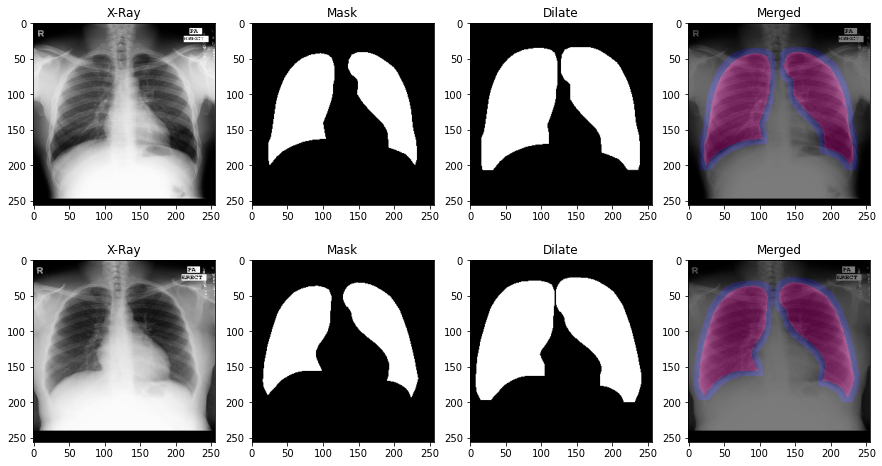

In [12]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(TRAIN_IMAGE_DIR, base_file)
mask_image_file = os.path.join(MASK_DIR, base_file)
dilate_image_file = os.path.join(DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(TEST_DIR, base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)
plt.show()

#### Shenzhen dataset preparation
- Resize Shenzhen Hospital chest x-ray images to 256X256 pixels
- Dilate masks to gain more information on the edge of lungs
- Split images into training and test datasets
- Write images to /segmentation directory

In [13]:
#shuffle shenzhen file list
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
random.shuffle(shenzhen_mask_dir)
print('shenzhen length: ',len(shenzhen_mask_dir))
#get shenzhen test data train data
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

shenzhen length:  566


In [14]:
SHENZHEN_IMAGE_DIR

'./datasets/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png'

In [15]:
for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (256, 256))
    #image = apply_clahe(image,15,(8,8))
    
    mask = cv2.resize(mask, (256, 256))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(TRAIN_IMAGE_DIR, base_file), image)
        cv2.imwrite(os.path.join(MASK_DIR, base_file), mask)
        cv2.imwrite(os.path.join(DILATE_DIR, base_file), mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(TEST_DIR, base_file), image)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [01:09<00:00,  8.15it/s]


Show some Shenzhen Hospital chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

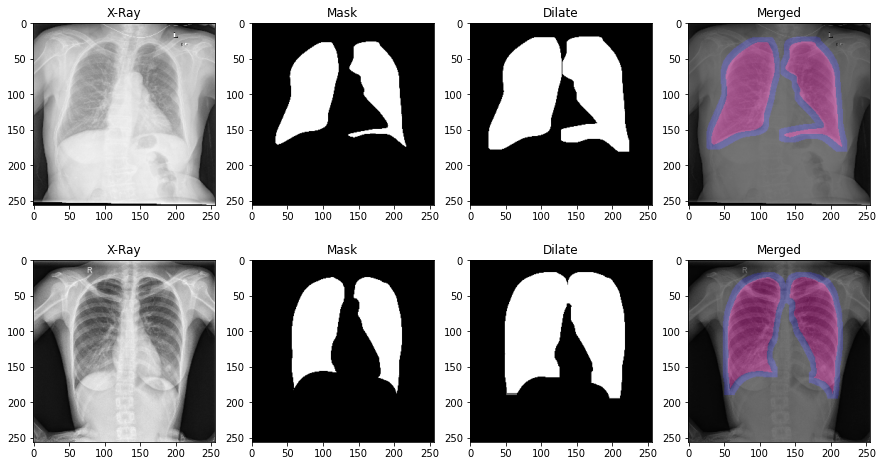

In [16]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(TRAIN_IMAGE_DIR, base_file)
mask_image_file = os.path.join(MASK_DIR, base_file)
dilate_image_file = os.path.join(DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(TEST_DIR, base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)
plt.show()

Print the count of images and segmentation lung masks available to test and train the model

In [17]:
train_files = glob(os.path.join(TRAIN_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(TEST_DIR, "*.png"))
mask_files = glob(os.path.join(MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 300, 604, 604)

` Montgomery County: 88 train, 50 test
 Shenzhen: 516 train, 50 test
 Total train: 604
 Total Test: 100 X3 types image`

### Segmentation Training

#### Data Augmentation

In [18]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=42):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

#### UNET Architecture

In [19]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    # CONTRACTING PATH
    # Downsampling 1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Downsampling 2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Downsampling 3
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Downsampling 4
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # EXPANDING PATH
    # Upsampling & Concatenate 1
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    # Upsampling & Concatenate 2
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Upsampling & Concatenate 3
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    # Upsampling & Concatenate 4
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Helper function to load test CXR images

In [20]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

`Select Test and Validation files`

In [21]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(256, 256)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(256, 256)))

len(test_files), len(validation_data)

(100, 2)

In [22]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


earlystop = EarlyStopping(monitor='loss',
                          min_delta=.0001,
                          patience=30,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

In [23]:
EPOCHS = 500
from keras.optimizers import adam_v2
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(256,256),
                            save_to_dir=None)
model = unet(input_size=(256,256,1))
model.compile(optimizer=adam_v2.Adam(learning_rate=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_without_clahe.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint,earlystop,reducelr],
                              validation_data = validation_data)

2022-07-02 18:26:33.972682: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-02 18:26:33.972745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6448 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

2022-07-02 18:26:37.140018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/18 [==============================] - ETA: 0s - loss: -0.4222 - dice_coef: 0.4222 - binary_accuracy: 0.6271
Epoch 00001: loss improved from inf to -0.42224, saving model to unet_lung_without_clahe.hdf5
18/18 [==============================] - 19s 654ms/step - loss: -0.4222 - dice_coef: 0.4222 - binary_accuracy: 0.6271 - val_loss: -0.4297 - val_dice_coef: 0.4297 - val_binary_accuracy: 0.6171 - lr: 1.0000e-05
Epoch 2/500
19/18 [==============================] - ETA: 0s - loss: -0.4235 - dice_coef: 0.4234 - binary_accuracy: 0.6136
Epoch 00002: loss improved from -0.42224 to -0.42346, saving model to unet_lung_without_clahe.hdf5
18/18 [==============================] - 6s 343ms/step - loss: -0.4235 - dice_coef: 0.4234 - binary_accuracy: 0.6136 - val_loss: -0.4300 - val_dice_coef: 0.4300 - val_binary_accuracy: 0.6161 - lr: 1.0000e-05
Epoch 3/500
19/18 [==============================] - ETA: 0s - loss: -0.4241 - dice_coef: 0.4242 - binary_accuracy: 0.5977
Epoch 00003: loss improved from -

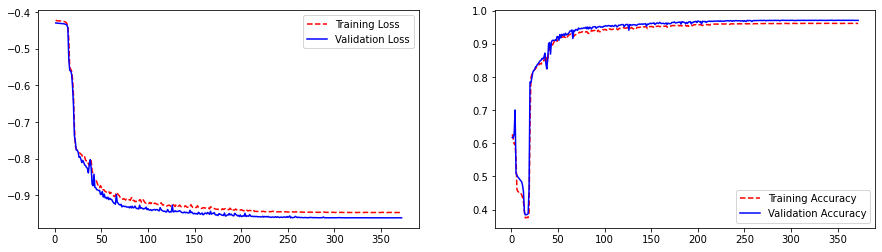

In [25]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()